# 🩺 Breast Cancer Detection Model Experimentation and Explanations
Early Cancer Detection is a must to begin a fight against the cancer to stop it from spreading and affecting the different regions, further complicating the treatment effectiveness.

Out of all other cancers, Breast cancer is the most prevalent. In 2022, an estimated [287,500 new cases](https://www.nationalbreastcancer.org/breast-cancer-facts) of invasive breast cancer will be diagnosed in women in the U.S. as well as 51,400 new cases of non-invasive (in-situ) breast cancer.

Hence, due to such an impact, it is necessary that we use any tool that helps us in early detection of cancer on set and try to get rid of it as soon as possible, saving numerous lives in the process.

<center><img src="https://media.giphy.com/media/YB9gabBBknol4gS8QQ/giphy.gif" heigth=100px width=150px></center>

Let us use the breast cancer ultrasound data set to build models that can classify images into normal, benign or malignant effectively.

# ⚓ Imports

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 👷 Defining some helper functions

In [3]:
def get_default_device():
    """
    Pick GPU if available, else CPU.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')



def to_device(data, device):
    """
    Move tensor(s) to chosen device.
    """
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)



class DeviceDataLoader():
    """
    Wrap a dataloader to move data to a device.
    """

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)



def eval_accuracy(loader, model_name):
    """
    Gives out accuracy for a model
    """
    model = model_name
    model.eval()
    corrects = 0
    total = 0
    for images, labels in loader:
        images, labels = to_device(images, device), to_device(labels, device)
        predictions = model(images)
        predict = to_device(torch.max(predictions.data, 1)[1], device)
        total += len(labels)
        corrects += (predict == labels).sum()
    accuracy = 100 * corrects / float(total)
    return accuracy



def plot_loss_curves(history):
    """
    Plots the curves for both loss and accuracy.
    """
    train_loss = [item['train_loss'] for item in history[1:]]
    val_loss = [item['val_loss'] for item in history[1:]]

    train_accuracy = [item['train_acc'] for item in history[1:]]
    val_accuracy = [item['val_acc'] for item in history[1:]]

    epochs = range(len(train_loss))

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax1 = sns.lineplot(x=epochs, y=train_loss, label='Training Loss', ax=ax[0])
    ax1 = sns.lineplot(x=epochs, y=val_loss, label='Validation Loss', ax=ax[0])
    ax1.set_title('Losses')
    ax2 = sns.lineplot(x=epochs, y=train_accuracy, label='Training Accuracy', ax=ax[1])
    ax2 = sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy', ax=ax[1])
    ax2.set_title('Accuracies')



def predict_image_from_test(model, index=None):
    """
    Outputs a random image from the test data (if the index is not given),
    with the index no., original label and the predicted label
    """
    if index is None:
        index = np.random.randint(len(test_ds_1)-1)
    img, label = test_ds_1[index]
    x = to_device(img.unsqueeze(0), device)
    y = model(x)
    _, preds  = torch.max(y, dim=1)
    print('Index no.:', index, ', Label:', classes[label], ', Predicted:', classes[preds[0].item()])
    plt.imshow(img.permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
random_seed = 42
torch.manual_seed(random_seed)

device = get_default_device()

#hyperparameters
BATCH_SIZE = 2
epochs = 50
L_R = 0.01                #learning rate
G_C = 0.1                 #gradient clipping
W_D = 1e-4                #weight decay
OPT_F = torch.optim.Adam  #optimizing function
patience = 3

# ❄️ Data Handling and Understanding

/content
['Dataset_BUSI_with_GT']
[PosixPath('drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal'), PosixPath('drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/malignant'), PosixPath('drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign')]
Number of training images: 780
Number of labels: 780
No. of classes:  3
Various Classes:  ['normal', 'malignant', 'benign']
Random image size:  (547, 473)


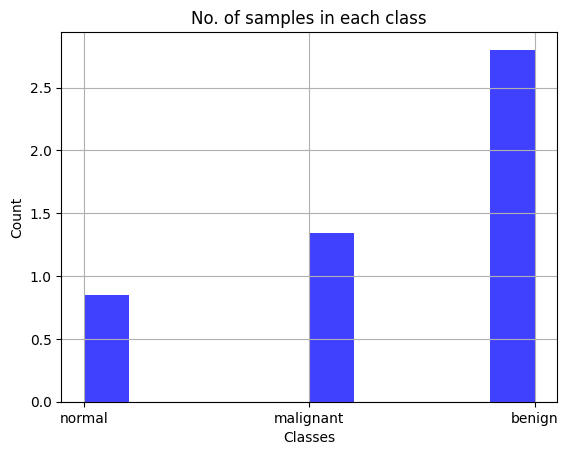

In [15]:

print(os.getcwd())
#root_dir = '../../data/Dataset_BUSI_with_GT'
root_dir = './drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT'
print(os.listdir('./drive/MyDrive/ML/BreastCancerProject/data'))
path = Path(root_dir)
print(list(path.glob('*')))
path_images = list(path.glob('**/*.png'))

images_paths = [str(path_image) for path_image in path_images if '_mask' not in str(path_image)]
print(f'Number of training images: {len(images_paths)}')

labels = [os.path.split(os.path.split(name)[0])[1] for name in images_paths]
print(f'Number of labels: {len(labels)}')

classes = list(set(labels))
labels_dict = {label : i for i,label in enumerate(classes)}
labels_val = [labels_dict[label_key] for label_key in labels]

print("No. of classes: ", len(classes))
print("Various Classes: ", classes)
img = Image.open(images_paths[18])
print("Random image size: ", img.size)

no_of_samples = pd.DataFrame(labels, columns=["class"])
plt.hist(no_of_samples, density=True, facecolor='b', alpha=0.75)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('No. of samples in each class')
plt.grid(True)
plt.show()

Randomly sampled images from the data: 


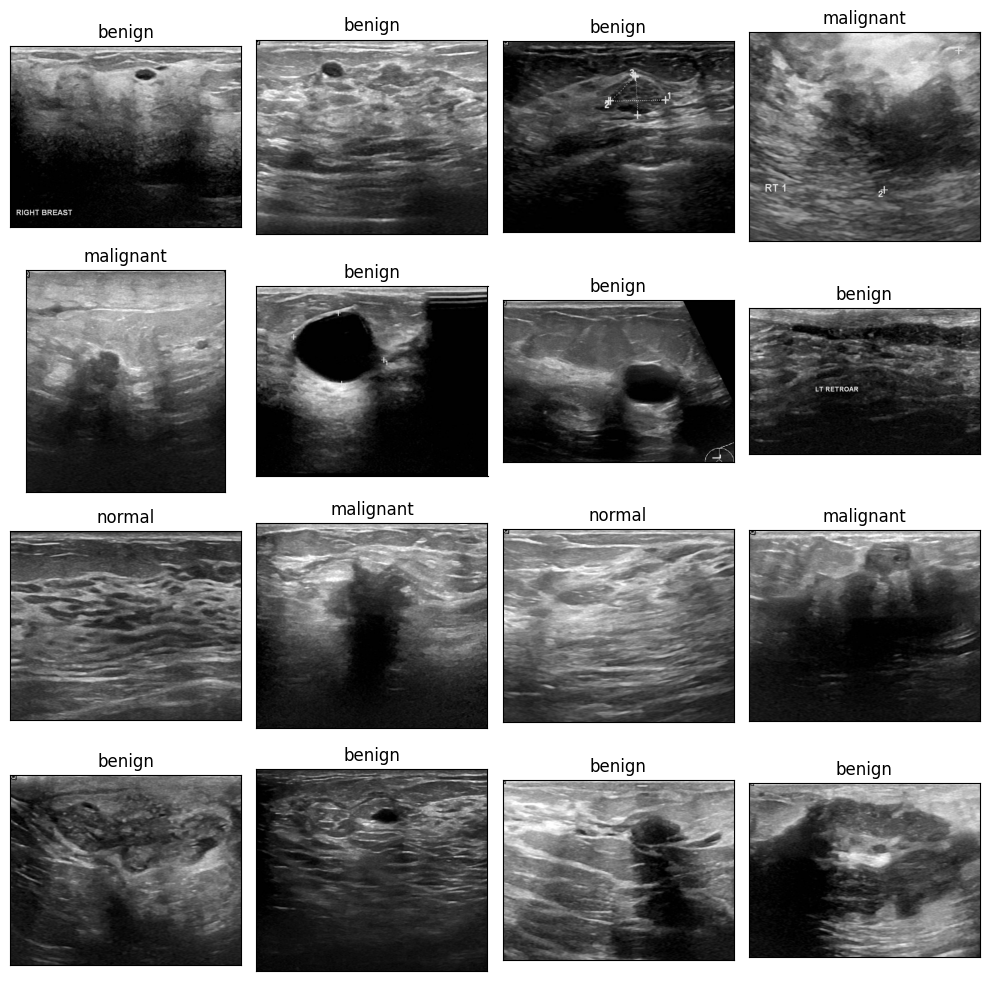

In [16]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(images_paths), 16)
fig, axes = plt.subplots(4,4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

print('Randomly sampled images from the data: ')

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(images_paths[random_index[i]]))
    ax.set_title(labels[random_index[i]])
plt.tight_layout()
plt.show()

# 🏗️ Data set Building

In [17]:
data, test_data, labels, test_labels = train_test_split(images_paths, labels_val, test_size=0.15, shuffle=True)
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.1, shuffle=True)

In [18]:
# a class to create data sets
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images: list, labels: list, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self, ):
        return len(self.labels)

    def __getitem__(self, index):
        image = Image.open(self.images[index])

        image = self.transform(image)

        label = self.labels[index]

        return image, label

In [19]:
# simple transformations
basic = T.Compose([
    T.Resize([324,324]),
    T.ToTensor()
    ])

In [21]:
#creating datasets with basically no augmentations
train_ds_1 = Dataset(images=train_data,labels=train_labels, transform=basic)
val_ds_1 = Dataset(images=val_data,labels=val_labels, transform=basic)
test_ds_1 = Dataset(images=test_data,labels=test_labels, transform=basic)

In [22]:
train_loader_1 = DataLoader(train_ds_1, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
val_loader_1 = DataLoader(val_ds_1, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader_1 = DataLoader(test_ds_1, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)

In [23]:
# sending data to the device i.e. CPU or a GPU whatever is available
train_dl_1 = DeviceDataLoader(train_loader_1, device)
valid_dl_1 = DeviceDataLoader(val_loader_1, device)

# 1️⃣ Modelling 1.0 - Without Transforms
I will first try to train a simple CNN model using a basic network by applying simple transforms. Let's check the results after training.

In [24]:
class TestModel(nn.Module):

    def __init__(self):
        super(TestModel, self).__init__()
        # 3 input image channels, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 24, 3)

        self.fc1 = nn.Linear(24 * 79 * 79, 2048)
        self.fc2 = nn.Linear(2048, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # changing the shape to pass to the next flattened layer
        x = x.view(x.size(0), 24 * 79 * 79)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

print(TestModel())

TestModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=149784, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
)


In [25]:
@torch.no_grad()
def accuracy(outputs, labels):
    """
    Function to calculate the accuracy.
    """
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/preds.size(0))


def evaluate(model, val_loader):
    """
    Function to evaluate the model and output scores such as validation loss and accuracy.
    """
    model.eval()

    val_losses, val_accuracy = [], []
    target_count, correct_val = 0, 0

    for images, labels in val_loader:
        target = labels.cuda()
        input_var = Variable(images, volatile=True)
        target_var = Variable(labels, volatile=True)

        out = model(images)                        #generate predictions
        val_loss = F.cross_entropy(out, labels)    #calculate loss

        _, predicted = torch.max(out.data, 1)      #calculate accuracy
        target_count += target_var.size(0)
        correct_val += (target_var==predicted).sum().item()
        val_acc = (100 * correct_val)/target_count

        #record the loss and training accuracy
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)

    val_loss = torch.stack(val_losses).mean().item()
    val_acc = sum(val_accuracy)/len(val_accuracy)

    return {'val_loss': val_loss, 'val_acc': val_acc}


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(model, train_loader, val_loader, epochs=epochs, max_lr=0.01, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, patience=patience):
    """
    Function to run the training loop with multiple hyperparameters.
    """
    torch.cuda.empty_cache()
    history = []

    #early stopping
    last_loss = 100
    triggertimes = 0

    #extras
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        #training loop
        model.train()

        train_accuracy = []
        train_losses = []
        lrs = []
        target_count = 0
        correct_train = 0

        for images, labels in tqdm(train_loader):
            target = labels.cuda()
            input_var = Variable(images)
            target_var = Variable(labels)

            #generating predictions on image
            out = model(images)

            #calculating loss
            loss = F.cross_entropy(out, labels)

            # accuracy
            _, predicted = torch.max(out.data, 1)
            target_count += target_var.size(0)
            correct_train += (target_var==predicted).sum().item()
            train_acc = (100 * correct_train)/target_count

            #record the loss and training accuracy
            train_losses.append(loss)
            train_accuracy.append(train_acc)

            #pass back the gradients calculated to the entire network
            loss.backward()

            #for gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            #does the weight update
            optimizer.step()

            #zero the gradient buffers else gradients will be accumulated to existing gradients
            optimizer.zero_grad()

            #record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        #model validation
        result = evaluate(model, val_loader)
        result['train_acc'] = sum(train_accuracy)/len(train_accuracy)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs

        #training loop output
        print(":::Epoch[{}]::: {} Training Acc.: {:.3f} %, Training Loss: {:.5f}".format(
            epoch, "Last LR: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_acc'], result['train_loss']))

        #early stopping [Sourced from: https://pythonguides.com/pytorch-early-stopping/]
        current_loss = result['val_loss']
        print(':::::::::::::: Current Validation Acc.: {:.3f} %\n:::::::::::::: Current Validation Loss: {:.5f}'.format(result['val_acc'], current_loss))

        if current_loss > last_loss:
            trigger_times += 1
            print('Patience triggered:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping activated!\nYour model has finished training!')
                history.append(result)
                break

        else:
            print('Model is improving...')
            trigger_times = 0

        last_loss = current_loss

        #finally appending the result
        history.append(result)

    print('Your model has finished training!')
    return history

In [26]:
# initializing the model and sending it to the device
model_1 = TestModel()
to_device(model_1, device)

TestModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=149784, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
)

In [27]:
# running a test run
history = [evaluate(model_1, valid_dl_1)]
history

[{'val_loss': 1.1090177297592163, 'val_acc': 21.38259297511079}]

In [ ]:
# model training begins
history += fit_one_cycle(model_1, train_dl_1, valid_dl_1, epochs=epochs, max_lr=L_R, weight_decay=W_D, grad_clip=None, opt_func=OPT_F)

  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[0]::: Last LR: 0.00050, Training Acc.: 51.598 %, Training Loss: 1.03234
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.96001
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[1]::: Last LR: 0.00081, Training Acc.: 53.332 %, Training Loss: 1.00507
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.94011
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[2]::: Last LR: 0.00132, Training Acc.: 54.462 %, Training Loss: 0.99274
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.96955
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[3]::: Last LR: 0.00199, Training Acc.: 55.925 %, Training Loss: 1.03311
:::::::::::::: Current Validation Acc.: 58.784 %
:::::::::::::: Current Validation Loss: 0.91390
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[4]::: Last LR: 0.00280, Training Acc.: 57.393 %, Training Loss: 1.01676
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95521
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[5]::: Last LR: 0.00371, Training Acc.: 55.509 %, Training Loss: 0.98557
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95546
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[6]::: Last LR: 0.00470, Training Acc.: 55.592 %, Training Loss: 0.98915
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95154
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[7]::: Last LR: 0.00570, Training Acc.: 57.225 %, Training Loss: 0.98734
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95466
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[8]::: Last LR: 0.00668, Training Acc.: 53.506 %, Training Loss: 0.98001
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.94962
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[9]::: Last LR: 0.00760, Training Acc.: 53.310 %, Training Loss: 0.99139
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.98641
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[10]::: Last LR: 0.00841, Training Acc.: 58.128 %, Training Loss: 0.98134
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95505
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[11]::: Last LR: 0.00908, Training Acc.: 52.085 %, Training Loss: 0.97891
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95191
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[12]::: Last LR: 0.00958, Training Acc.: 58.927 %, Training Loss: 0.97894
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95426
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[13]::: Last LR: 0.00990, Training Acc.: 57.150 %, Training Loss: 0.97847
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95706
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[14]::: Last LR: 0.01000, Training Acc.: 54.702 %, Training Loss: 0.97782
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.94707
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[15]::: Last LR: 0.00998, Training Acc.: 54.892 %, Training Loss: 0.98116
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95546
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[16]::: Last LR: 0.00992, Training Acc.: 55.735 %, Training Loss: 0.98088
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.96130
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[17]::: Last LR: 0.00982, Training Acc.: 54.820 %, Training Loss: 0.97879
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95328
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[18]::: Last LR: 0.00968, Training Acc.: 53.992 %, Training Loss: 0.98003
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95463
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[19]::: Last LR: 0.00950, Training Acc.: 53.310 %, Training Loss: 0.98013
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95215
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[20]::: Last LR: 0.00929, Training Acc.: 58.520 %, Training Loss: 0.97814
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.96007
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[21]::: Last LR: 0.00905, Training Acc.: 54.024 %, Training Loss: 1.01595
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.97210
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[22]::: Last LR: 0.00877, Training Acc.: 53.328 %, Training Loss: 0.98091
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95268
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[23]::: Last LR: 0.00846, Training Acc.: 58.149 %, Training Loss: 0.97802
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95631
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[24]::: Last LR: 0.00812, Training Acc.: 51.029 %, Training Loss: 0.97893
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95261
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[25]::: Last LR: 0.00775, Training Acc.: 54.365 %, Training Loss: 0.97952
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95420
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[26]::: Last LR: 0.00737, Training Acc.: 58.165 %, Training Loss: 0.97909
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95710
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[27]::: Last LR: 0.00697, Training Acc.: 58.127 %, Training Loss: 0.98221
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95293
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[28]::: Last LR: 0.00655, Training Acc.: 53.637 %, Training Loss: 0.97856
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95352
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[29]::: Last LR: 0.00611, Training Acc.: 55.220 %, Training Loss: 0.97841
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95256
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[30]::: Last LR: 0.00567, Training Acc.: 54.134 %, Training Loss: 0.97935
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95377
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[31]::: Last LR: 0.00522, Training Acc.: 54.496 %, Training Loss: 0.97791
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95252
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[32]::: Last LR: 0.00478, Training Acc.: 55.724 %, Training Loss: 0.97803
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95305
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[33]::: Last LR: 0.00433, Training Acc.: 57.721 %, Training Loss: 0.97743
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95605
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[34]::: Last LR: 0.00389, Training Acc.: 56.682 %, Training Loss: 0.97771
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95597
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[35]::: Last LR: 0.00345, Training Acc.: 58.217 %, Training Loss: 0.97736
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95615
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[36]::: Last LR: 0.00303, Training Acc.: 52.001 %, Training Loss: 0.97764
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95310
Model is improving...


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[37]::: Last LR: 0.00263, Training Acc.: 54.259 %, Training Loss: 0.97720
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95434
Patience triggered: 1


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[38]::: Last LR: 0.00225, Training Acc.: 53.184 %, Training Loss: 0.97701
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95468
Patience triggered: 2


  0%|          | 0/298 [00:00<?, ?it/s]

:::Epoch[39]::: Last LR: 0.00188, Training Acc.: 57.789 %, Training Loss: 0.97659
:::::::::::::: Current Validation Acc.: 55.260 %
:::::::::::::: Current Validation Loss: 0.95525
Patience triggered: 3
Early stopping activated!
Your model has finished training!
Your model has finished training!


##  Results 1.0

In [ ]:
# accuracy on test images
test_acc_1 = eval_accuracy(test_loader_1, model_1)
print(f' Accuracy on test images: {test_acc_1}')

 Accuracy on test images: 55.55555725097656


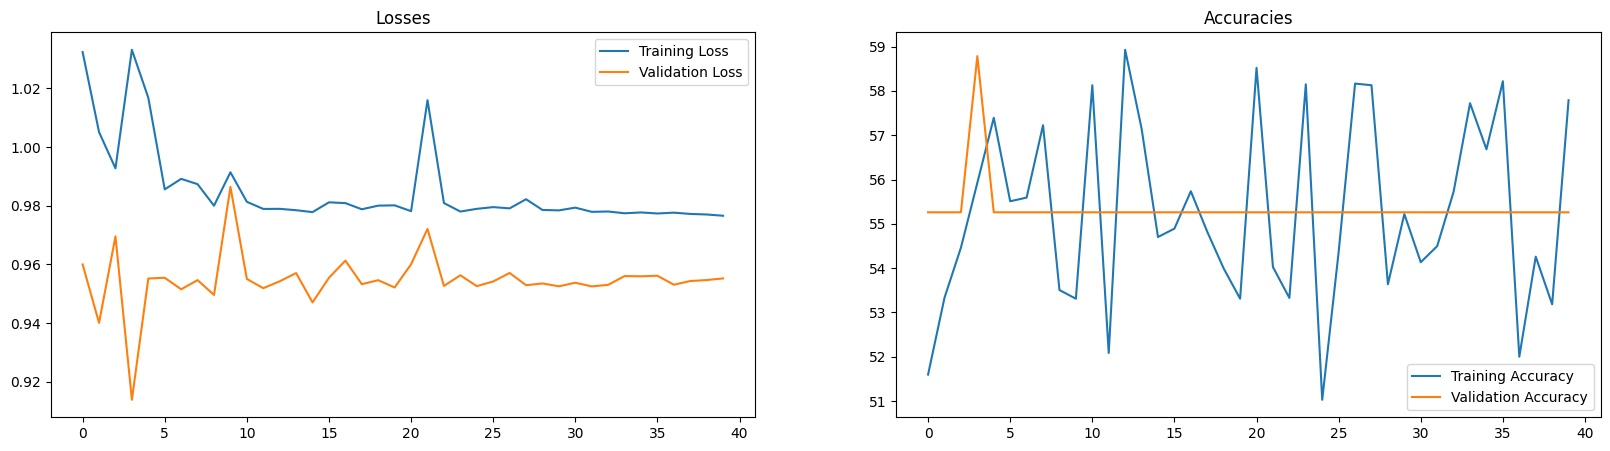

In [ ]:
plot_loss_curves(history=history)

Index no.: 84 , Label: normal , Predicted: benign


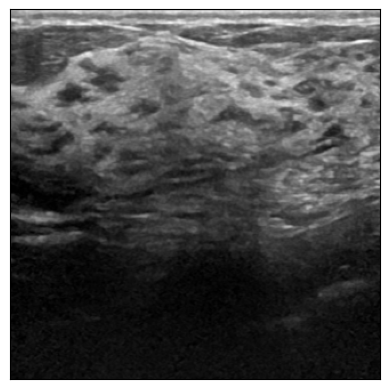

In [ ]:
predict_image_from_test(model_1)

# 2️⃣ Modelling 2.0: Image Augmentation
Let's do another training run with the images augmented.

In [ ]:
train_transforms = T.Compose(
    [
        T.Resize([324,324]),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ],
)

val_transforms = T.Compose(
    [
        T.Resize([324,324]),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ],
)

In [ ]:
# generating new data sets with image augmentations applied
train_ds_2 = Dataset(images=train_data,labels=train_labels,transform=train_transforms)
val_ds_2 = Dataset(images=val_data,labels=val_labels,transform=val_transforms)
test_ds_2 = Dataset(images=test_data,labels=test_labels,transform=val_transforms)

In [ ]:
train_loader_2 = DataLoader(train_ds_2, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
val_loader_2 = DataLoader(val_ds_2, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
test_loader_2 = DataLoader(test_ds_2, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)

In [ ]:
train_dl_2 = DeviceDataLoader(train_loader_2, device)
valid_dl_2 = DeviceDataLoader(val_loader_2, device)

In [ ]:
model_2 = TestModel()
to_device(model_2, device)

TestModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=149784, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
history = [evaluate(model_2, valid_dl_2)]
history

[{'val_loss': 1.0729069709777832, 'val_acc': 57.12230964772856}]

In [ ]:
history += fit_one_cycle(model_2, train_dl_2, valid_dl_2, epochs=epochs, max_lr=L_R, weight_decay=W_D, grad_clip=None, opt_func=OPT_F)

## Results 2.0

In [ ]:
test_acc_2 = eval_accuracy(test_loader_2, model_2)
print(f' Accuracy on test images: {test_acc_2}')

In [ ]:
plot_loss_curves(history)

In [ ]:
import gc

#del model_1
#del model_2

gc.collect()
torch.cuda.empty_cache()

# 3️⃣ Modelling 3.0: Transfer Learning
As we've seen that using a simple network won't get us far. We might try to use a complicated structure for neural nets such as UNet (as others have tried). But, I will just use a ResNet18 to get the final model.

In [ ]:
#initializing a simple ResNet-50 model;
class ResNet34Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        self.network.pool1 = nn.AvgPool2d(2)
        self.network.fc = nn.Linear(self.network.fc.in_features, len(classes))

    def forward(self, x):
        return self.network(x)

In [ ]:
model_3 = ResNet34Model()
to_device(model_3, device)

In [ ]:
history = [evaluate(model_3, valid_dl_2)]
history

In [ ]:
history += fit_one_cycle(model_3, train_dl_2, valid_dl_2, epochs=epochs, max_lr=L_R, weight_decay=W_D, grad_clip=None, opt_func=OPT_F, patience=4)

## Results 3.0

In [ ]:
test_acc_3 = eval_accuracy(test_loader_2, model_3)
print(f' Accuracy on test images: {test_acc_3}')

In [ ]:
plot_loss_curves(history)

# 📜Final Results

In [ ]:
test_accs = [test_acc_1.cpu(), test_acc_2.cpu(), test_acc_3.cpu()]
test_accs = pd.DataFrame(test_accs, columns=["test_accs"])
test_accs["models"] = ["Model 1", "Model 2", "Model 3"]
plt.bar(test_accs["models"], test_accs["test_accs"], facecolor='g', alpha=0.60)
plt.xlabel('Different Models')
plt.ylabel('Test Accuracies')
plt.title('Accuracy comparison for all the models')
plt.show()

# 👄 Explaining the results
With a critical use case such as cancer detection it is necessary that we are able to explain the results or the reasoning behind a model's decision to every stakeholder involved. As the model's decisions will directly affect the further treatment, it will be beneficial if the model is able to explain itself and point out where it "looks" while saying that a certain image is Cancer or not.

I used Saliency maps here, which is a commonly used explanatory method. There are multiple methods out there that too can be used here.

In [ ]:
def saliency(model, test_ds, index):
    """
    Draws a saliency map for a given index image to explain the model's decision making process.
    """
    for param in model.parameters():
        param.requires_grad = False

    model.eval()
    image, label = test_ds[index]
    img = image.unsqueeze(0)
    img = img.cuda()
    img.requires_grad = True

    preds = model(img)
    score, indices = torch.max(preds, 1)
    score.backward()

    s, _ = torch.max(torch.abs(img.grad[0]), dim=0)
    s = (s-s.min())/(s.max()-s.min())

    #plot image and its saliency map
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    print("Class: ", classes[label])
    print("Prediction: ", classes[indices])
    ax[0].set_title('Original')
    ax[0].axis('off')
    ax[1].imshow(s.cpu().numpy(), cmap='plasma') #set any of the cmap from here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    ax[1].set_title('Saliency Map')
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
saliency(model_3, test_ds_2, index=55)

#### The saliency map generated above shows where the model will pay the most attention while predicting (the bright spots). This helps experts understand whether the model should be approved for deployment or not based on the areas it targets the most.

#### For instance, a model might look directly look at the tumour before predicting or might look completely elsewhere before predicting. Regardless of the prediction, the model focusing on the right part of the image are the ones on the right track.

>## This concludes my experimentation on building a good classifying model for detecting breast cancer from ultrasounds. Here, the performance is not that great which can be attributed to the lower no. of images but still it was a good learning experience for me.
>## ✌️Hope you found it interesting and helpful too.
>## 🤸‍Do **upvote** so that others can find this nb. Thanks for coming till the end!!

# 📑 References
[Saliency maps.](https://towardsdatascience.com/saliency-map-using-pytorch-68270fe45e80)
